In [1]:
import sys
sys.path.append("../") # go to parent dir

import numpy as np
from matplotlib import pyplot as plt
import module.chebyshev_solver as chb

import jax.numpy as jnp

In [2]:
np.set_printoptions(precision=3)

In [3]:
N_coeff = 50

dims = (N_coeff, N_coeff)

In [4]:
grid = np.cos((2*np.arange(N_coeff) + 1)*np.pi/2/N_coeff)

yy, xx = np.meshgrid(grid, grid)

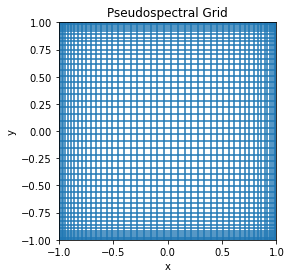

In [13]:
for x in grid:
    plt.axvline(x)
    plt.axhline(x)

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect('equal')
plt.title("Pseudospectral Grid")
plt.savefig("../plot/grid.pdf")

In [6]:
I_ = np.zeros((N_coeff, N_coeff))

for i in range(N_coeff):
    cat = np.zeros(N_coeff)
    cat[i] = 1
    I_[:, i] = np.polynomial.chebyshev.chebval(grid, cat)

In [7]:
D_ = np.zeros((N_coeff, N_coeff))

for i in range(N_coeff):
    cat = np.zeros(N_coeff)
    cat[i] = 1

    Cheb = np.polynomial.chebyshev.Chebyshev(cat)
    D_[:, i] = Cheb.deriv(m = 1)(grid)


D2_ = np.zeros((N_coeff, N_coeff))

for i in range(N_coeff):
    cat = np.zeros(N_coeff)
    cat[i] = 1

    Cheb = np.polynomial.chebyshev.Chebyshev(cat)
    D2_[:, i] = Cheb.deriv(m = 2)(grid)

## make 2D

In [8]:
I = np.kron(I_, I_)

In [9]:
Dx = np.kron(D_, I_)
Dy = np.kron(I_, D_)

In [10]:
D2x = np.kron(D2_, I_)
D2y = np.kron(I_, D2_)

DxDy = np.kron(D_, D_)

In [11]:
coeff = np.zeros((N_coeff, N_coeff))
coeff[1, 2] = 1
im = (DxDy @ coeff.flatten()).reshape((N_coeff, N_coeff))

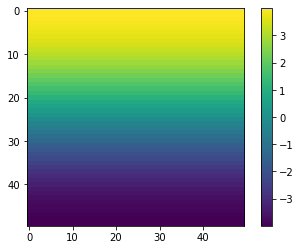

In [12]:
plt.imshow(im.T)
plt.colorbar()

In [13]:
def boundify(op):
    for i in range(N_coeff*N_coeff):
        cond = False

        ## y boundaries
        
        if i % N_coeff == 0:
            cond = True

        if i % N_coeff == N_coeff - 1:
            cond = True


        ## x boundaries

        if i < N_coeff:
            cond = True

        if i >= N_coeff*N_coeff - N_coeff:
            cond = True

        if cond:
            op[i,:] = I[i, :]

    return op

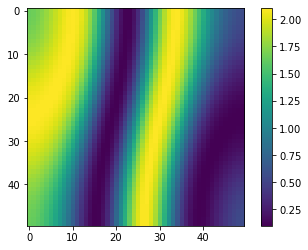

In [14]:
k = -np.sin(yy*1.5*np.pi + xx) + 1.1
plt.imshow(k)
plt.colorbar()
k_cheby = np.linalg.inv(I) @ k.flatten()


k = I @ k_cheby
kx = Dx @ k_cheby
ky = Dy @ k_cheby
k_mat = np.diag(k)
kx_mat = np.diag(kx)
ky_mat = np.diag(ky)

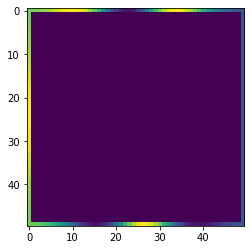

In [15]:
boundary = np.zeros((N_coeff,N_coeff))
boundary[0,:] = k.reshape(dims)[0,:]
boundary[-1, :] = k.reshape(dims)[-1,:]
boundary[:, 0] = k.reshape(dims)[:,0]
boundary[:, -1] = k.reshape(dims)[0,-1]

plt.imshow(boundary)
boundary = boundary.flatten()

In [16]:
L = boundify(kx_mat @ Dx + ky_mat @ Dy + k_mat @ (D2x + D2y))
sol = np.linalg.inv(L) @ boundary 

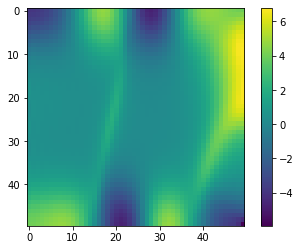

In [17]:
im = I @ sol
Tx = Dx @ sol
Ty = Dy @ sol
plt.imshow(im.reshape(dims))
plt.imshow(Ty.reshape(dims))

plt.colorbar()

In [18]:
solver = chb.Solver(N_coeff)

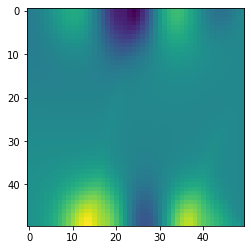

In [25]:
sol = solver.solve(k_cheby, boundary)
plt.imshow(sol["dx T"].reshape(dims))

In [20]:
A = sol["T"] - im

In [21]:
np.mean(A)

Array(2.393e-11, dtype=float64)

In [22]:
np.std(A)

Array(5.86e-11, dtype=float64)

In [23]:
L.dtype

dtype('float64')

In [24]:
solver.calc_L(k_cheby).dtype

dtype('float64')